In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from __future__ import print_function
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import sys
import os
import glob

sys.path.insert(0, '../fcn8s')
from fcn8s import Inference

import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import (KMeans, DBSCAN, AgglomerativeClustering, MiniBatchKMeans)
from sklearn.metrics import (cohen_kappa_score, confusion_matrix, classification_report)

# For permutation tests
from sympy.utilities.iterables import multiset_permutations

from MulticoreTSNE import MulticoreTSNE as MTSNE

# config = tf.ConfigProto( device_count = {'GPU': 0} )

colors = [ 'firebrick', 'olivedrab', 'blueviolet', 'goldenrod', 'lightsalmon' ]
labels = ['G3', 'G4', 'G5', 'BN', 'ST']

In [3]:
# MODULE_URL = 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1'; MODULE_NAME='InceptionV3'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/1'; MODULE_NAME='NasNet'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/1'; MODULE_NAME='Resnet50'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/1'; MODULE_NAME='Resnet101'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/1'; MODULE_NAME='Resnet152'
MODULE_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_035_224/feature_vector/1'; MODULE_NAME='MobilenetV2'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/1'; MODULE_NAME='InceptionResnet'

# config = tf.ConfigProto( device_count = {'GPU': 0} )
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

module = hub.Module(MODULE_URL)
height, width = hub.get_expected_image_size(module)
print(height, width)

image_in = tf.placeholder('float', [1, height, width, 3])
z_op = module(image_in)
sess.run(tf.global_variables_initializer())

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/Conv/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/Conv/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/wei

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/weights:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_1/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_12/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_14/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_14/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_14/expand/Ba

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/weights:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_16

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/weights:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_3/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_3/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_3/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_mean
INFO:ten

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/weights:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_5/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_6/depthwi

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expand

## Populate a matrix of feature vectors

In [4]:
!ls ../data/jpg | wc -l

625


In [9]:
jpg_list = sorted(glob.glob('../data/jpg/*.jpg'))
mask_list = sorted(glob.glob('../data/mask/*.png'))

img_classes = []
orig_imgs = []

z_vectors = []
idx = 0

resize = 0.5
crop_size = int(height * (1/resize))

samples = 5
x0_vect = np.linspace(0, 1200-crop_size, samples, dtype=np.int)
y0_vect = np.linspace(0, 1200-crop_size, samples, dtype=np.int)
coords = zip(x0_vect, y0_vect)

for img_idx, (jpg, mask) in enumerate(zip(jpg_list, mask_list)):
    y = cv2.imread(mask, -1)
    x = cv2.imread(jpg, -1)[:,:,::-1]
               
    for k in range(samples):
        x0 = np.random.randint(0, 1200-crop_size)
        y0 = np.random.randint(0, 1200-crop_size)
        
        ## Grab the majority label
        y_ = y[x0:x0+crop_size, y0:y0+crop_size]
        totals = np.zeros(5)
        for k in range(5):
            totals[k] = (y_==k).sum()

        # Check for majority
        maj = np.argmax(totals)   
        if totals[maj] > 0.5 * (crop_size**2):
            # check for stroma -- two ways to skip stroma
            if maj==4 and totals[maj] < 0.95 * (crop_size*2):
                continue
            elif maj==4 and np.random.randn(1) < 0.5:
                continue
        else:
            continue

        img_classes.append(maj)
        orig_imgs.append(img_idx)
        idx += 1
        if idx % 250 == 0:
            print('[{} / {}]'.format(img_idx, len(jpg_list)))
        x_ = x[x0:x0+crop_size, y0:y0+crop_size, :]
        x_ = cv2.resize(x_, dsize=(0,0), fx=resize, fy=resize)
        x_ = x_ * (1/255.)
        x_ = np.expand_dims(x_, 0)
        
        z = sess.run(z_op, feed_dict={image_in: x_})

        z_vectors.append(z)
    
    
z_vectors = np.concatenate(z_vectors, axis=0)

img_classes = np.asarray(img_classes)
orig_imgs = np.asarray(orig_imgs)
print('z vectors', z_vectors.shape)
print('img classes', img_classes.shape)
print('got classes:', np.unique(img_classes))

manifold = MTSNE(n_jobs=8, n_components=2, verbose=1)
z_manifold = manifold.fit_transform(z_vectors)
print('z manifold', z_manifold.shape)

[113 / 625]
[214 / 625]
[266 / 625]
[329 / 625]
[433 / 625]
[509 / 625]
[601 / 625]
z vectors (1828, 1280)
img classes (1828,)
got classes: [0 1 2 3 4]
z manifold (1828, 2)


## Cluter the z vectors

In [13]:
# clusterer = KMeans(n_clusters=5, n_jobs=4, verbose=0, n_init=25).fit(z_vectors)
clusterer = MiniBatchKMeans(n_clusters=5, verbose=0, n_init=100).fit(z_vectors)

In [16]:
# Compare label assignments with the annotation
clustered = clusterer.labels_

max_kappa = 0.0
best_remapped = None

for _ in range(10):
    clusterer = MiniBatchKMeans(n_clusters=5, verbose=0, n_init=100).fit(z_vectors)
    for perm in multiset_permutations(range(5)):
        # Pick a mapping clustered --> labels
        mapping = {x: k for x, k in zip(range(5), perm)}

        clustered_remapped = np.asarray([mapping[y] for y in clustered])

        kappa = cohen_kappa_score(img_classes, clustered_remapped)

        if kappa > max_kappa:
            best_remapped = clustered_remapped
            max_kappa = kappa
            print(kappa)
            print(mapping)
            print(classification_report(img_classes, clustered_remapped), end='\n\n')

0.099189904946688
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
             precision    recall  f1-score   support

          0       0.24      0.66      0.36       210
          1       0.02      0.01      0.01       670
          2       0.50      0.86      0.63       279
          3       0.45      0.62      0.52       164
          4       0.01      0.00      0.01       505

avg / total       0.16      0.27      0.19      1828


0.1955757286502786
{0: 0, 1: 3, 2: 2, 3: 4, 4: 1}
             precision    recall  f1-score   support

          0       0.24      0.66      0.36       210
          1       0.78      0.27      0.40       670
          2       0.50      0.86      0.63       279
          3       0.00      0.00      0.00       164
          4       0.24      0.11      0.15       505

avg / total       0.46      0.33      0.32      1828


0.23383049854840698
{0: 0, 1: 4, 2: 1, 3: 3, 4: 2}
             precision    recall  f1-score   support

          0       0.24      0.66      0.36    

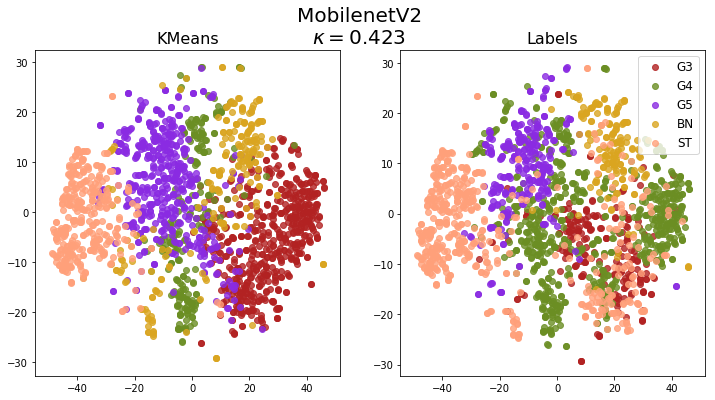

In [17]:
fig, axs = plt.subplots(1,2, figsize=(12, 6))

for k in range(5):
    idxs = np.where(best_remapped==k)
    sns.regplot(z_manifold[idxs,0], z_manifold[idxs,1], fit_reg=False, color=colors[k], ax=axs[0])
    
    idxs = np.where(img_classes==k)
    sns.regplot(z_manifold[idxs,0], z_manifold[idxs,1], fit_reg=False, color=colors[k], label=labels[k], ax=axs[1])

axs[0].set_title('KMeans', fontsize=16)
axs[1].set_title('Labels', fontsize=16)
plt.legend(fontsize=12)
plt.suptitle(u'{}\n$\kappa={:3.3f}$'.format(MODULE_NAME, max_kappa), fontsize=20)
plt.savefig('/home/nathan/Dropbox/_papers/gleason_grade/{}_kmeans.pdf'.format(MODULE_NAME), bbox_inches='tight')